In [2]:
import tensorflow as tf
# print('import tf', tf.__version__)

import os,pickle
import time
import datetime
from imp import reload
from matplotlib import pyplot as plt
import numpy as np
import sys
from units.globals import DEBUG
from units.globals import DEBUG,NEWPATH,N_CPU
import argparse

from units.base import visualize,generate_images,show
from units.dataloader import load_np_data
from sklearn.model_selection import train_test_split

In [2]:
argv=["ipykernel_launcher.py","-b","1","-e","200","-m","pet_cycgan"]

In [4]:
sys.argv=["ipykernel_launcher.py","-e","200","-m","logs/54612"]

In [5]:
parser=argparse.ArgumentParser(description="cyc_GAN_model")
parser.add_argument("-l","--lamda",type=float,default=10, help="set cycle-consistency lamda value")
parser.add_argument("-b","--batch_size",type=int,default=1, help="set batch size")
parser.add_argument("-e","--epoches",type=int,default=200, help="set epoches")
parser.add_argument("-m","--model_path",default=None, help="set pretrained model path")
parser.add_argument("-a","--argument",type=bool,default=False, help="whether use argument")
args = parser.parse_args()

LAMDA=args.lamda
BATCH_SIZE=args.batch_size
EPOCHES=args.epoches
MODEL_PATH=args.model_path
ARGU=args.argument


['datasets/brainmap/npdata_t2/1 - 副本 (2).npz', 'datasets/brainmap/npdata_t2/1 - 副本.npz', 'datasets/brainmap/npdata_t2/1.npz', 'datasets/brainmap/npdata_t2/100 - 副本 (2).npz', 'datasets/brainmap/npdata_t2/100 - 副本.npz', 'datasets/brainmap/npdata_t2/100.npz', 'datasets/brainmap/npdata_t2/2 - 副本 (2).npz', 'datasets/brainmap/npdata_t2/2 - 副本.npz', 'datasets/brainmap/npdata_t2/2.npz', 'datasets/brainmap/npdata_t2/294.npz', 'datasets/brainmap/npdata_t2/339.npz', 'datasets/brainmap/npdata_t2/4 - 副本 (2).npz', 'datasets/brainmap/npdata_t2/4 - 副本.npz', 'datasets/brainmap/npdata_t2/4.npz']


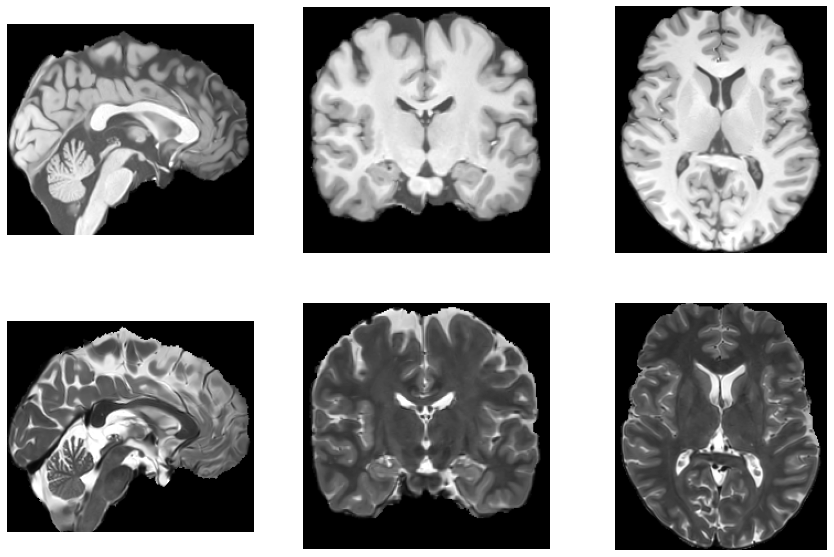

In [12]:
# reload(GAN)
load_mods=["T1","T2"]
NEWPATH="datasets/brainmap/npdata_t2"
data=[f"{NEWPATH}/{img}"for img in os.listdir(NEWPATH)]
print(data)
demo=np.load(data[3])
t1,fa=demo[load_mods[0]],demo[load_mods[1]]
# t1[fa==0]=0
visualize([t1,fa],save_path="demo/paired.png")

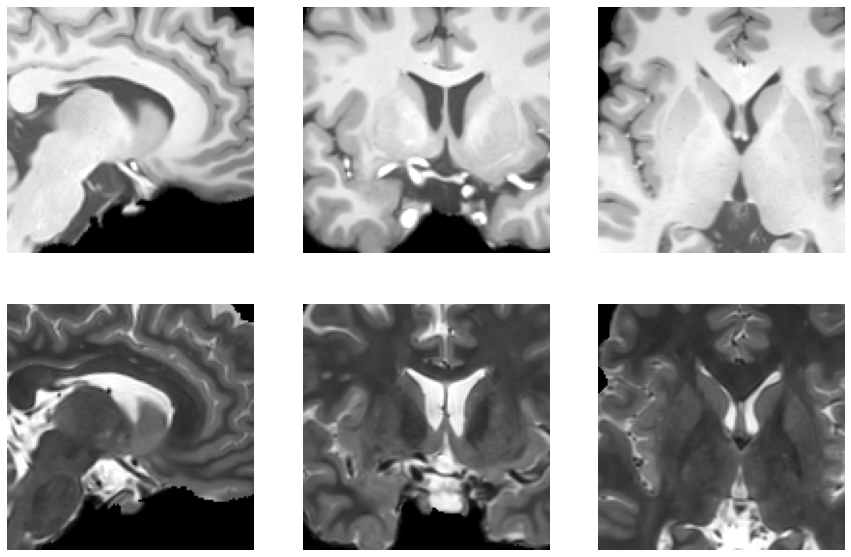

In [13]:
from units.dataloader import load_np_data

t1_arg,fa_arg=load_np_data(data[0],load_mods,ARGU)
# print(t1_arg.shape)
# t1_arg,fa_arg=load_image_train(t1_arg,fa_arg)#,[Rotation3D(max_rate=np.pi/2)])
visualize([t1_arg[...,0],fa_arg[...,0]])
np.save("demo/t1_arg",t1_arg)
np.save("demo/fa_arg",fa_arg)

In [14]:
data=[f"{NEWPATH}/{img}"for img in os.listdir(NEWPATH)]
train_val,test=train_test_split(
    data,test_size=0.1,random_state=1919810
)
train,val=train_test_split(
    train_val,test_size=0.1,random_state=114514
)
show(f"Train len: {len(train)}")
show(f"Val len: {len(val)}")
show(f"Test len: {len(test)}")

Train len: 10
Val len: 2
Test len: 2


In [15]:
# The facade training set consist of 400 images

BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
# st_range=np.array((227, 272, 227))-np.array((128,128,128))

train_load=lambda filename:tf.numpy_function(func=load_np_data,inp=[filename,load_mods,ARGU],Tout=(tf.float32,tf.float32))
test_load=lambda filename:tf.numpy_function(func=load_np_data,inp=[filename,load_mods,False],Tout=(tf.float32,tf.float32))

def get_train_ds(train):
    # train_dataset=[]
    # for t in tqdm(train):
        # train_dataset.append(load_image_train(t))
    # train_dataset=np.array(train_dataset)
    # train_dataset = list(map(load_image_train,train))
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train)
    # print(train_dataset)
    # train_dataset=load_image_train(train)
    train_dataset = train_dataset.map(map_func=train_load,num_parallel_calls=N_CPU)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE,seed=114514)
    train_dataset = train_dataset.batch(BATCH_SIZE,num_parallel_calls=N_CPU)
    return train_dataset
# train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))

def get_test_ds(test):
    # test_dataset=[]
    # for i in range(8):test_dataset+=[load_image_test(test_dir)for test_dir in test]
    # iplist,relist=[],[]
    # for input,real in test_dataset:
    #     iplist.append(input)
    #     relist.append(real)
    test_dataset = tf.data.Dataset.from_tensor_slices(test)
    test_dataset = test_dataset.map(map_func=test_load,num_parallel_calls=N_CPU)
    # test_dataset = test_dataset.map(lambda x:tf.numpy_function(func=load_image_test,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=16,deterministic=False)
    # test_dataset = test_dataset.map(lambda x:tf.numpy_function(func=load_image_test,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
    test_dataset = test_dataset.batch(BATCH_SIZE,num_parallel_calls=N_CPU)
    return test_dataset

train_ds,val_ds,test_ds=get_train_ds(train),get_test_ds(val),get_test_ds(test)

In [ ]:
from GAN.model import Pix2pix
from units.base import generate_images,visualize

tip,fip=t1_arg,fa_arg
p2pgan=Pix2pix(tip.shape,example_data=[tip,fip])
G,D=p2pgan.G,p2pgan.D
if MODEL_PATH is not None:
    p2pgan.load_model(MODEL_PATH)
p2pgan.generate_images([tip[...,0],fip[...,0]])

T2_metric=p2pgan.eval_result(test_ds)
print("T2_metric:",T2_metric)
# generate_images(G,tip[...,0],fip[...,0])
# print(p2pgan.test_step(tip[tf.newaxis,...],fip[tf.newaxis,...]))

In [ ]:
tot_step=len(train_ds)*200
h=p2pgan.train(train_ds,val_ds,steps=tot_step)
with open(f"{p2pgan.log_dir}/training_log.pic","wb") as f:
    pickle.dump(h,f)
from units.base import show_process
show_process(h["train"],labels=p2pgan.outputs,save_path=f"{p2pgan.log_dir}/train_process")
show_process(h["valid"],labels=p2pgan.outputs, save_path=f"{p2pgan.log_dir}/valid_process")

In [ ]:
MODEL1_PATH=MODEL_PATH
MODEL2_PATH=MODEL_PATH

imgA,imgB=tip[tf.newaxis,...],fip[tf.newaxis,...]
px1=Pix2pix(tip.shape,example_data=[tip,fip])
px1.load_model(MODEL1_PATH)
G1=px1.G
px2=Pix2pix(tip.shape,example_data=[tip,fip])
px2.load_model(MODEL2_PATH)
G2=px2.G


# A_delta,B_delta=[tf.zeros(tip[tf.newaxis,...].shape)],[]
SA_A,SA_B=[imgA],[]
SB_A,SB_B=[],[imgB]
# p2pgan.generate_images([tip[...,0],fip[...,0]])
for i in range(3):
    SA_B.append(G1(SA_A[-1]))
    SA_A.append(G2(SA_B[-1]))
    SB_A.append(G2(SB_B[-1]))
    SB_B.append(G1(SB_A[-1]))
d_A=[imgA-fakei for fakei in SA_A[1:]]
D_B=[imgB-fakei for fakei in SA_B[:]]
D_A=[imgA-fakei for fakei in SB_A[:]]
d_B=[imgB-fakei for fakei in SA_B[1:]]


In [18]:
def get_delta(G1,G2,imgA,imgB,tms=3):
    SA_A,SA_B=[imgA],[]
    SB_A,SB_B=[],[imgB]
    # p2pgan.generate_images([tip[...,0],fip[...,0]])
    for i in range(tms):
        SA_B.append(G1(SA_A[-1]))
        SA_A.append(G2(SA_B[-1]))
        SB_A.append(G2(SB_B[-1]))
        SB_B.append(G1(SB_A[-1]))
    d_A=[fakei-imgA for fakei in SA_A[1:]]
    D_B=[fakei-imgB for fakei in SA_B[:]]
    D_A=[fakei-imgA for fakei in SB_A[:]]
    d_B=[fakei-imgB for fakei in SB_B[1:]]
    return SA_A[1:],SB_A,d_A,D_A,SA_B,SB_B[1:],d_B,D_B



In [19]:
def get_half_delta(G1,G2,imgA,tms=3):
    SA_A,SA_B=[imgA],[]
    # SB_A,SB_B=[],[imgB]
    # p2pgan.generate_images([tip[...,0],fip[...,0]])
    for i in range(tms):
        SA_B.append(G1(SA_A[-1]))
        SA_A.append(G2(SA_B[-1]))
        # SB_A.append(G2(SB_B[-1]))
        # SB_B.append(G1(SB_A[-1]))
    d_A=[fakei-imgA for fakei in SA_A[1:]]
    # D_B=[fakei-imgB for fakei in SA_B[:]]
    # D_A=[fakei-imgA for fakei in SB_A[:]]
    # d_B=[fakei-imgB for fakei in SB_B[1:]]
    return SA_A[1:],SA_B,d_A
    # return SA_A[1:],SB_A,d_A,D_A,SA_B,SB_B[1:],d_B,D_B

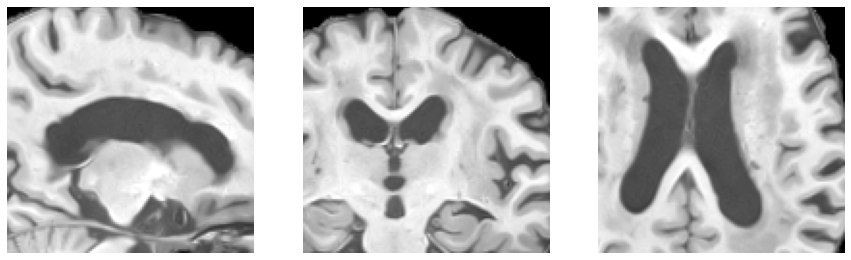

(128, 128, 128)


In [21]:
from pet_cycgan import Cycgan_pet
from units.base import visualize
from units.prep import random_jitter,normalize
import tensorflow as tf
import nibabel as nib
import numpy as np

# data=[f"datasets/brainmap/npdata/{img}"for img in os.listdir("datasets/brainmap/npdata")]

# t1_arg,fa_arg=load_np_data(data[3],["T1","FA"],ARGU)
img=nib.load(r"C:\Users\CH2\Documents\大学课程\毕业设计\work\4.26\mci\1\t1_brain_ACPC.nii.gz").get_fdata()
img=normalize(img)
t1_arg=img[17:-18,26:-22,5:-30]
x,y,z=np.array(t1_arg.shape)//2
x+=16
z+=24
p,q,r=np.array([128]*3)//2
t1_arg=t1_arg[x-p:x+p,y-q:y+q,z-r:z+r]
# t1_arg=tf.pad(t1_arg,[[16,16],[0,0],[16,16]],"CONSTANT")
visualize([t1_arg[...]])
print(t1_arg.shape)

cycgan=Cycgan_pet(t1_arg.shape+(1,))
cycgan.load_model("logs/54612")

# t1_arg,fa_arg=random_jitter(np.array([img,img]))
# SA_A,SB_A,d_A,D_A,SA_B,SB_B,d_B,D_B=get_delta(cycgan.G1,cycgan.G2,t1_arg[tf.newaxis,...],fa_arg[tf.newaxis,...])



In [22]:
SA_A,SA_B,d_A=get_half_delta(cycgan.G1,cycgan.G2,t1_arg[tf.newaxis,...,tf.newaxis])


ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


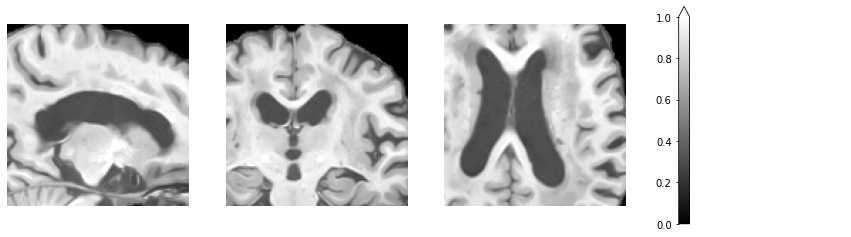

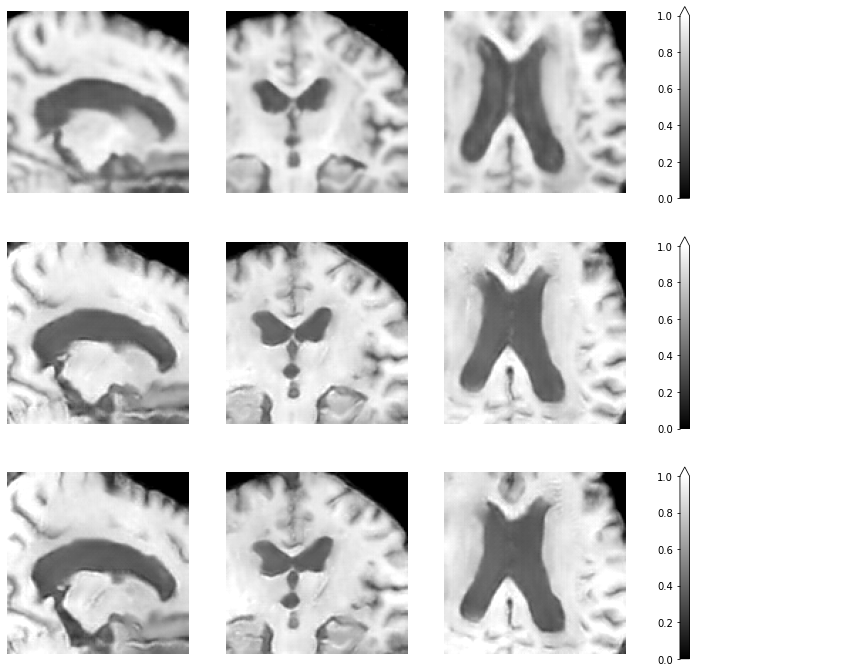

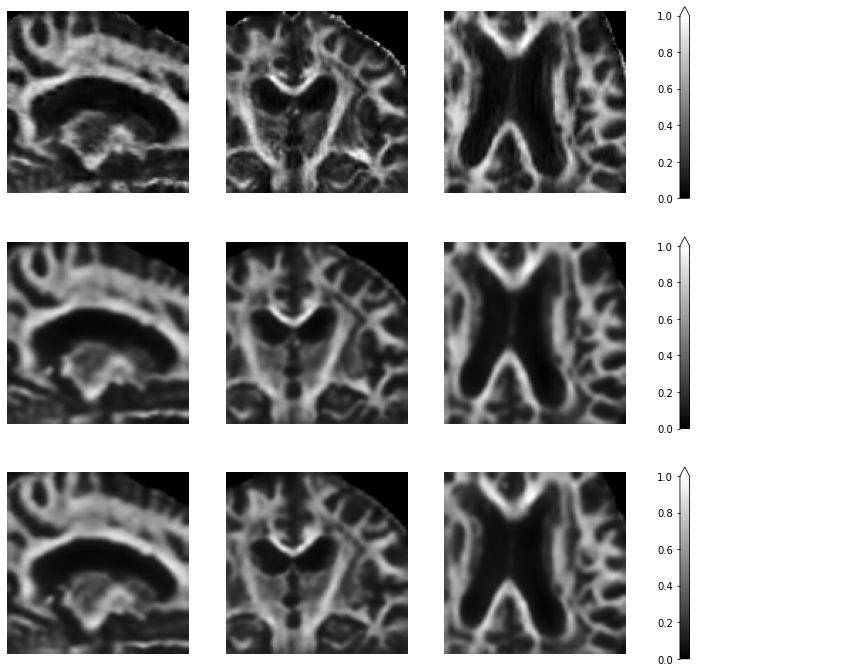

In [23]:
# visualize(cycgan.G1(t1_arg[tf.newaxis,...])[0,...,0])
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def visualize(X, title="", save_path=None):
    if not isinstance(X, list):
        X = [X]
    # plt.title(title)
    plt.figure(figsize=(15, 4*len(X)))
    cp=cm.get_cmap('gray')
    for i, x in enumerate(X):
        a, b, c = x.shape

        plt.subplot(len(X), 4, 4*i+1)
        plt.imshow(np.rot90(x[a//2, :, :]),vmin=0,vmax=1,cmap=cp)
        plt.axis('off')
        plt.subplot(len(X), 4, 4*i+2)
        plt.imshow(np.rot90(x[:, b//2, :]),vmin=0,vmax=1,cmap=cp)
        plt.axis('off')
        plt.subplot(len(X), 4, 4*i+3)
        plt.imshow(np.rot90(x[:, :, c//2]),vmin=0,vmax=1,cmap=cp)
        plt.axis('off')
        plt.subplot(len(X), 4, 4*i+4)
        plt.axis('off')
        plt.colorbar(location='left',extend="max")
        # plt.pcolor(X, Y, v, cmap=cm)
    # plt.clim(-1,1,extend="both")  # identical to caxis([-4,4]) in MATLAB
        
    if save_path is not None:
        plt.savefig(save_path, dpi=100)
    if DEBUG:
        plt.show()
    plt.close()
visualize([t1_arg[...]])
visualize([img[0,...,0]for img in SA_A])
# visualize([img[0,...,0]for img in d_A])
# visualize([img[0,...,0]for img in SB_A])

# visualize([fa_arg[...,0]])
# visualize([img[0,...,0]for img in SB_B])
visualize([img[0,...,0]for img in SA_B])

# SA_A[0].shape
# t1_arg.shape

ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


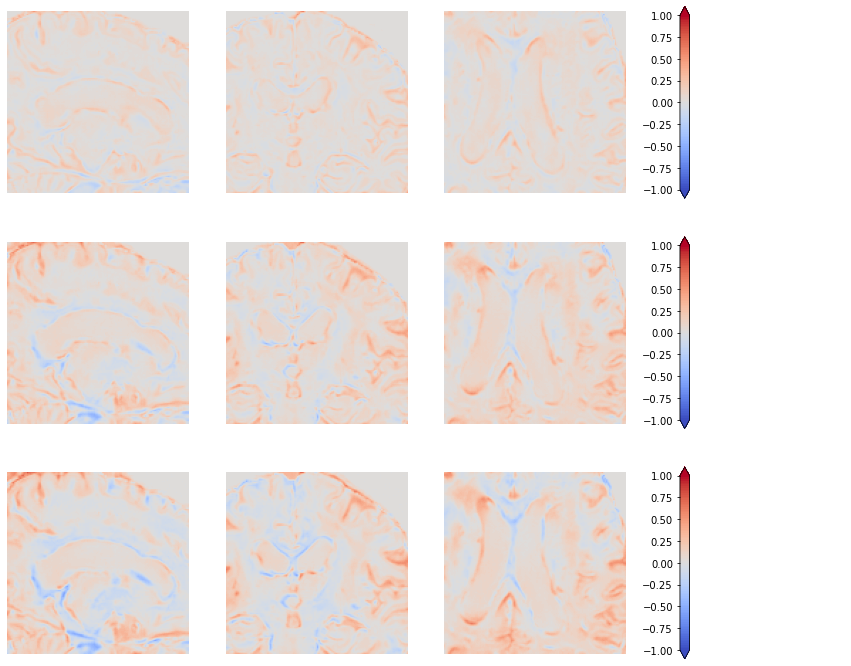

NameError: name 'D_A' is not defined

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.random.seed(23)


def visualize_delta(X, title="", save_path=None):
    if not isinstance(X, list):
        X = [X]
    # plt.title(title)
    plt.figure(figsize=(15, 4*len(X)))
    cp=cm.get_cmap('coolwarm',lut=100)
    for i, x in enumerate(X):
        a, b, c = x.shape

        plt.subplot(len(X), 4, 4*i+1)
        plt.imshow(np.rot90(x[a//2, :, :]),vmin=-1,vmax=1,cmap=cp)
        plt.axis('off')
        plt.subplot(len(X), 4, 4*i+2)
        plt.imshow(np.rot90(x[:, b//2, :]),vmin=-1,vmax=1,cmap=cp)
        plt.axis('off')
        plt.subplot(len(X), 4, 4*i+3)
        plt.imshow(np.rot90(x[:, :, c//2]),vmin=-1,vmax=1,cmap=cp)
        plt.axis('off')
        plt.subplot(len(X), 4, 4*i+4)
        plt.axis('off')
        plt.colorbar(location='left',extend="both")
        # plt.pcolor(X, Y, v, cmap=cm)
    # plt.clim(-1,1,extend="both")  # identical to caxis([-4,4]) in MATLAB
        
    if save_path is not None:
        plt.savefig(save_path, dpi=100)
    if DEBUG:
        plt.show()
    plt.close()

visualize_delta([img[0,...,0]for img in d_A])
visualize_delta([img[0,...,0]for img in D_A])

visualize_delta([img[0,...,0]for img in d_B])
visualize_delta([img[0,...,0]for img in D_B])

In [ ]:
from pet_cycgan import Cycgan_pet

cycgan=Cycgan_pet()
cycgan.load_model("logs/54612")

data=[f"datasets/brainmap/npdata/{img}"for img in os.listdir("datasets/brainmap/npdata")]

t1_arg,fa_arg=load_np_data(data[3],["T1","FA"],ARGU)

SA_A,SB_A,d_A,D_A,SA_B,SB_B,d_B,D_B=get_delta(cycgan.G1,cycgan.G2,t1_arg[tf.newaxis,...],fa_arg[tf.newaxis,...])


In [45]:
def visualize(X, title="", save_path=None):
    if not isinstance(X, list):
        X = [X]
    # plt.title(title)
    plt.figure(figsize=(15, 5*len(X)))
    cp=cm.get_cmap('gray')
    for i, x in enumerate(X):
        a, b, c = x.shape

        plt.subplot(len(X), 4, 4*i+1)
        plt.imshow(np.rot90(x[a//2, :, :]),vmin=0,vmax=1,cmap=cp)
        plt.axis('off')
        plt.subplot(len(X), 4, 4*i+2)
        plt.imshow(np.rot90(x[:, b//2, :]),vmin=0,vmax=1,cmap=cp)
        plt.axis('off')
        plt.subplot(len(X), 4, 4*i+3)
        plt.imshow(np.rot90(x[:, :, c//2]),vmin=0,vmax=1,cmap=cp)
        plt.axis('off')
        plt.subplot(len(X), 4, 4*i+4)
        plt.axis('off')
        plt.colorbar(location='left',extend="max")
        # plt.pcolor(X, Y, v, cmap=cm)
    # plt.clim(-1,1,extend="both")  # identical to caxis([-4,4]) in MATLAB
        
    if save_path is not None:
        plt.savefig(save_path, dpi=100)
    if DEBUG:
        plt.show()
    plt.close()
visualize([t1_arg[...,0]])
visualize([img[0,...,0]for img in SA_A])
visualize([img[0,...,0]for img in SB_A])

visualize([fa_arg[...,0]])
visualize([img[0,...,0]for img in SB_B])
visualize([img[0,...,0]for img in SA_B])

# SA_A[0].shape
# t1_arg.shape

ValueError: not enough values to unpack (expected 3, got 2)

<Figure size 1080x360 with 0 Axes>

In [41]:
# from pet_cycgan import Cycgan_pet
from GAN.model import Pix2pix
t1t2,t2t1=Pix2pix(),Pix2pix()
t1t2.load_model("T1_T2")
t2t1.load_model("T2_T1")
# data=[f"datasets/brainmap/npdata/{img}"for img in os.listdir("datasets/brainmap/npdata")]

t1_arg,fa_arg=load_np_data(data[0],["T1","T2"],ARGU)

SA_A,SB_A,d_A,D_A,SA_B,SB_B,d_B,D_B=get_delta(t1t2.G,t2t1.G2,t1_arg[tf.newaxis,...],fa_arg[tf.newaxis,...])


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'T1_T2/G.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:

SA_A,SB_A,d_A,D_A,SA_B,SB_B,d_B,D_B=get_delta(cycgan.G1,cycgan.G2,t1_arg[tf.newaxis,...],fa_arg[tf.newaxis,...])

(128, 128, 128, 1)


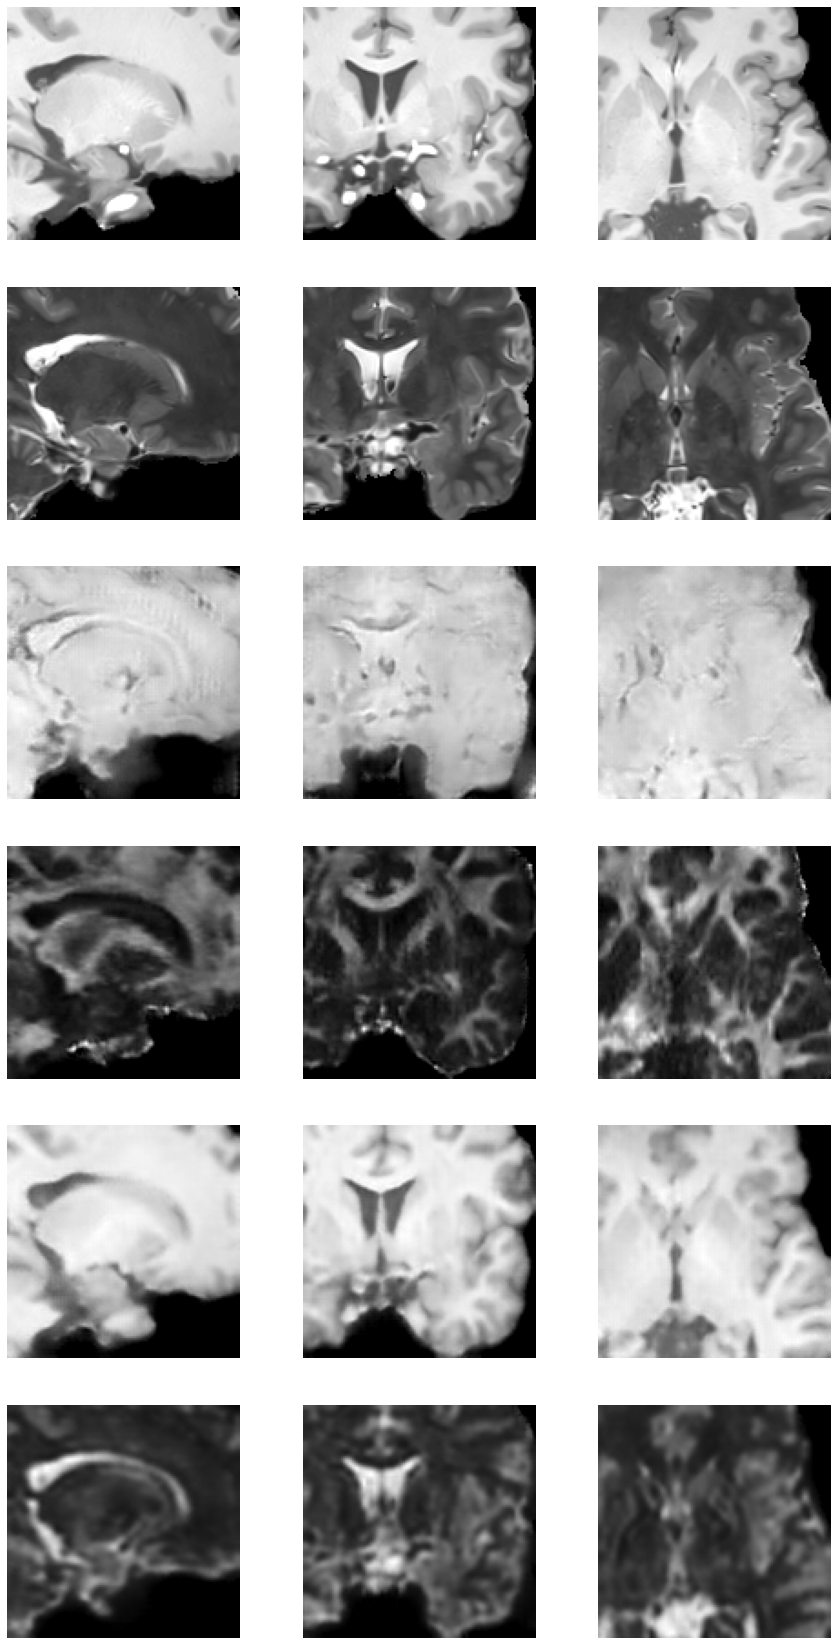

T1_metric: {'MSE': 0.01573922486976955, 'SSIM': 0.7301299836847579, 'PSNR': 18.33325643472778, 'NMI': 1.1347100621489203}
T2_metric: {'MSE': 0.020128658834065442, 'SSIM': 0.6403214183635957, 'PSNR': 16.986274219981524, 'NMI': 1.1037610941493567}


In [ ]:
# del Generator
from pet_cycgan import Cycgan_pet
from units.base import cyc_generate_images,generate_images,visualize

tip,fip=t1_arg,fa_arg

print(tip.shape)
# tip,fip=t1_arg[0:128,0:128,0:128],fa_arg[0:128,0:128,0:128]
cycgan=Cycgan_pet(tip.shape,lamda=LAMDA,example_data=[tip,fip])
if MODEL_PATH is not None:
    cycgan.load_model(MODEL_PATH)
cycgan.generate_images([tip[...,0],fip[...,0]])

T1_metric,T2_metric=cycgan.eval_result(test_ds)
print("T1_metric:",T1_metric)
print("T2_metric:",T2_metric)

# print(cycgan.test_step(tip[tf.newaxis,...],fip[tf.newaxis,...]))

Time taken for 1 dataload: 2.44 sec

Step 1/1800
G1_loss : 1.705787
G2_loss : 1.551225
DA_loss : 1.011732
DB_loss : 1.002338
cyc_loss_A : 0.530297
cyc_loss_B : 0.299579
tot_cyc_loss : 0.829876

Time taken for 1 steps: 197.84 sec

Val_step: 0/100
Train loss:
G1_loss : 1.705787
G2_loss : 1.551225
DA_loss : 1.011732
DB_loss : 1.002338
cyc_loss_A : 0.530297
cyc_loss_B : 0.299579
tot_cyc_loss : 0.829876

Val loss:
G1_loss : 1.491934
G2_loss : 1.750250
DA_loss : 0.921359
DB_loss : 0.885153
cyc_loss_A : 0.540862
cyc_loss_B : 0.304528
tot_cyc_loss : 0.845390



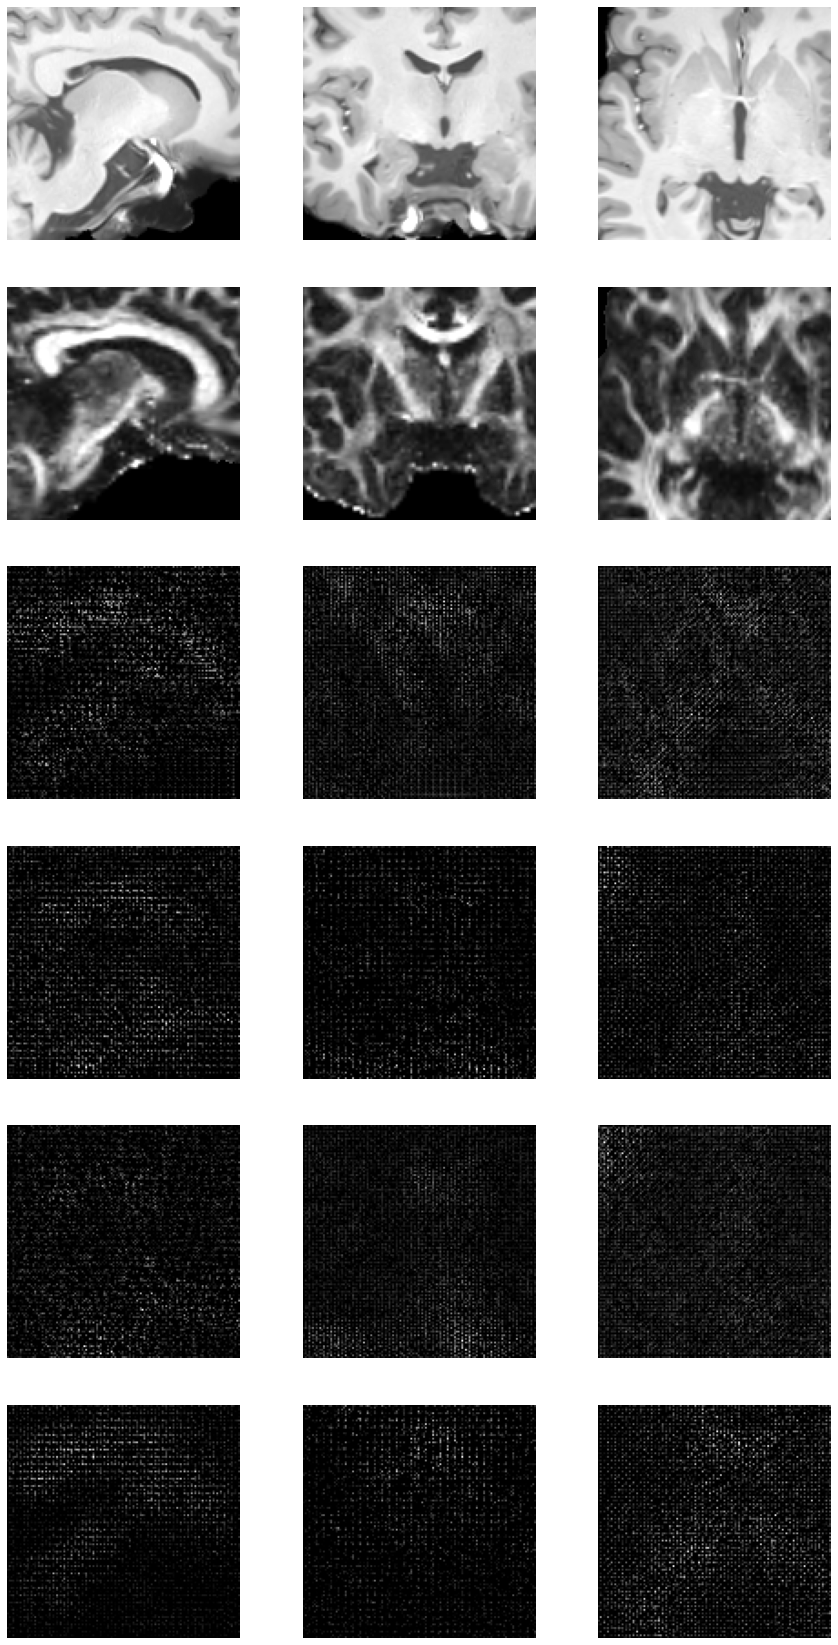

Validation loss decresaed from inf to 3.2422. Models' weights are now saved.
Time taken for 1 dataload: 0.01 sec

Step 2/1800
G1_loss : 1.586292
G2_loss : 1.803463
DA_loss : 0.812408
DB_loss : 0.938736
cyc_loss_A : 0.598468
cyc_loss_B : 0.318317
tot_cyc_loss : 0.916785

Time taken for 1 steps: 182.25 sec

Time taken for 1 dataload: 0.02 sec

Step 3/1800


KeyboardInterrupt: 

In [8]:
tot_step=len(train_ds)*EPOCHES
h=cycgan.train(train_ds,val_ds,steps=tot_step)
with open(f"{cycgan.log_dir}/training_log.pic","wb") as f:
    pickle.dump(h,f)
from units.base import show_process
show_process(h["train"],labels=cycgan.outputs ,save_path=f"{cycgan.log_dir}/train_process")
show_process(h["valid"],labels=cycgan.outputs, save_path=f"{cycgan.log_dir}/valid_process")

### END

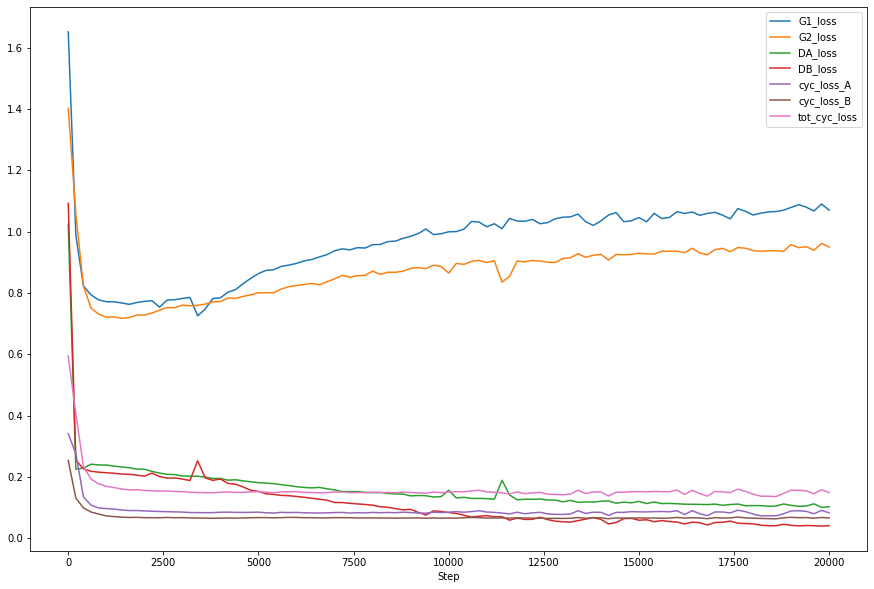

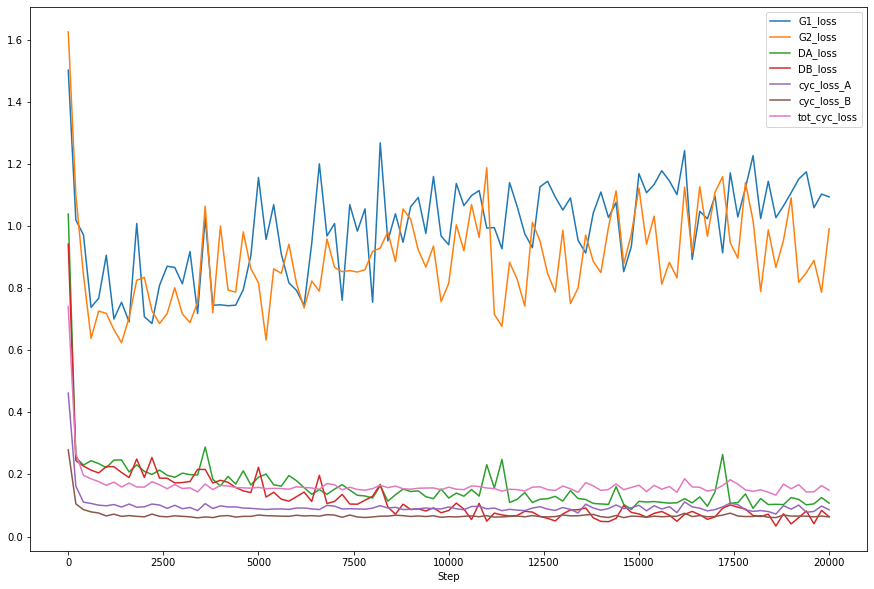

In [13]:
from units.base import show_process
import pickle
with open(f"logs/lamda120220411-005333/training_log.pic","rb") as f:
    h=pickle.load(f)
show_process(h["train"],labels=cycgan.outputs)
show_process(h["valid"],labels=cycgan.outputs)

In [ ]:
import pickle
fin_log_dir="logs/lamda120220409-160103"
# fin_log_dir="train_gan.job"
with open(f"{fin_log_dir}/training_log.pic","rb") as f:
    t=pickle.load(f)


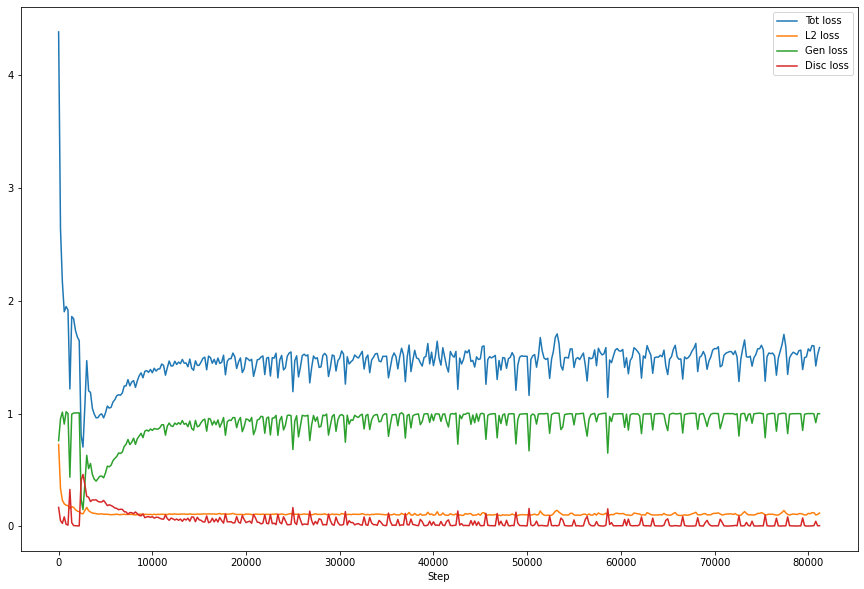

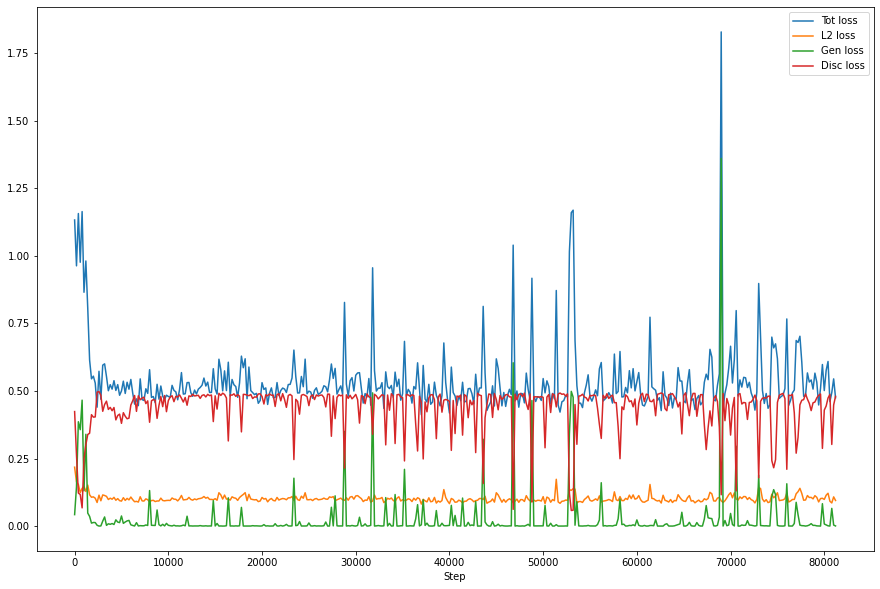

In [ ]:
import matplotlib.pyplot as plt
def show_train_result(pic_data,save_path=None):
    plt.figure(figsize=(15,10))
    x=range(0,len(pic_data)*200,200)
    # plt.yscale('log')
    plt.xlabel("Step")
    plt.plot(x,pic_data,label=["Tot loss","L2 loss","Gen loss","Disc loss"])
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
# plt.plot(x,t["val"],label="GAN loss")
show_train_result(t["train"],fin_log_dir+"train_result")
show_train_result(t["valid"],fin_log_dir+"valid_result")

In [ ]:
from GAN.model import Generator,Discriminator
# reload(GAN.model)
G = Generator()
D=Discriminator()

# G.summary(line_length=120)
D.summary(line_length=120)

Model: "Discriminator"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_image (InputLayer)               [(None, 128, 128, 128, 1)] 0                                                     
________________________________________________________________________________________________________________________
target_image (InputLayer)              [(None, 128, 128, 128, 1)] 0                                                     
________________________________________________________________________________________________________________________
concatenate_31 (Concatenate)           (None, 128, 128, 128, 2)   0             input_image[0][0]                       
                                                                                target_image[0][0]                      
_________

In [ ]:
#try tensor.map
train_dataset = tf.data.Dataset.from_tensor_slices(train)
# d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
    return t.decode('utf-8')+"1",t.decode('utf-8')+"2"
# d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
        #   inp=[x], Tout=tf.string))
# list(d.as_numpy_iterator())
train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))
# train_dataset=train_dataset.map(lambda x:tf.strings.as_string(x)+"2")
list(train_dataset.as_numpy_iterator())
# len(train_dataset.map(np.array))
# for i in train_dataset:
    # print()#.numpy())


In [ ]:
from numpy.random import randint
d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
  return (t.decode('utf-8')+str(randint(10))).upper()
d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
          inp=[x], Tout=tf.string),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
list(d.repeat().take(10).as_numpy_iterator())
# list(d.as_numpy_iterator())

[b'HELLO3',
 b'WORLD3',
 b'HELLO9',
 b'WORLD2',
 b'HELLO9',
 b'WORLD5',
 b'HELLO4',
 b'WORLD2',
 b'HELLO8',
 b'WORLD2']